In [1]:
import time
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
from numpy import loadtxt
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

## LSTM-A

In [2]:
#import the train and test files for financial news
fnews_Xtrain = loadtxt('data/train/fnews_Xtrain_.csv', delimiter=',')
fnews_Xtest = loadtxt('data/test/fnews_Xtest_.csv', delimiter=',')
fnews_ytrain = loadtxt('data/train/fnews_ytrain_.csv',delimiter=',')
fnews_ytest = loadtxt('data/test/fnews_ytest_.csv',delimiter=',')

In [3]:
#convert to array of integers from full precision
fnews_Xtrain=fnews_Xtrain.astype(int)
fnews_Xtest=fnews_Xtest.astype(int)
fnews_ytrain=fnews_ytrain.astype(int)
fnews_ytest=fnews_ytest.astype(int)

In [4]:
#check the respective shape of the train and test sets
print('Xtrain:',fnews_Xtrain.shape, 'ytrain:' ,fnews_ytrain.shape)
print('Xtest:',fnews_Xtest.shape, 'ytest:' ,fnews_ytest.shape)

Xtrain: (3876, 38) ytrain: (3876, 3)
Xtest: (970, 38) ytest: (970, 3)


In [5]:
#create the LSTM Model
## LSTM is an artificial recurrent neural network architecture and instead of standard feedforward neural network,
## LSTM has feedback connections (signals traveling in both areas)

#from preprocessing
vocab_length = 9242

model = Sequential()
#first embedding layer converts each word into a fixed-length vector of defined size
model.add(Embedding(vocab_length, 20, input_length = fnews_Xtrain.shape[1]))
#prevent overfitting with Dropout which is a type of dropout for convolutional networks
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(3,activation="softmax"))

In [6]:
#introduce callbacksto ensure training is stopped when the validation error starts increasing
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 3)

In [13]:
# output model skeleton
learning_rate = 0.05
model.summary()
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),loss="categorical_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 38, 20)            184840    
                                                                 
 conv1d (Conv1D)             (None, 38, 32)            1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

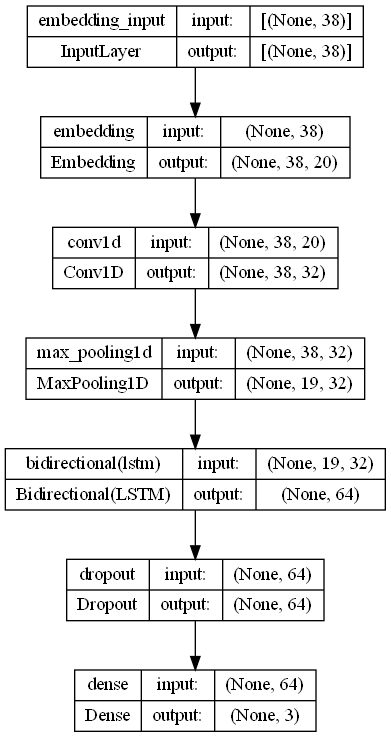

In [14]:
#show model
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
# ensure 100 epoch and start training the model
#set batch size to 32
batch_size = 32

start = time.time()
history = model.fit(fnews_Xtrain, fnews_ytrain, validation_data=(fnews_Xtest, fnews_ytest), 
                          epochs = 50, callbacks = early_stop, batch_size = batch_size)
end = time.time()

Epoch 1/50
122/122 [==============================] - 7s 19ms/step - loss: 0.8406 - acc: 0.6347 - val_loss: 0.8211 - val_acc: 0.6433
Epoch 2/50
122/122 [==============================] - 1s 10ms/step - loss: 0.8232 - acc: 0.6442 - val_loss: 0.8593 - val_acc: 0.6371
Epoch 3/50
122/122 [==============================] - 1s 11ms/step - loss: 0.8115 - acc: 0.6473 - val_loss: 0.8310 - val_acc: 0.6639
Epoch 4/50
122/122 [==============================] - 1s 10ms/step - loss: 0.7917 - acc: 0.6571 - val_loss: 0.7941 - val_acc: 0.6619
Epoch 5/50
122/122 [==============================] - 1s 11ms/step - loss: 0.7719 - acc: 0.6636 - val_loss: 0.7539 - val_acc: 0.6794
Epoch 6/50
122/122 [==============================] - 2s 13ms/step - loss: 0.7389 - acc: 0.6803 - val_loss: 0.7939 - val_acc: 0.6784
Epoch 7/50
122/122 [==============================] - 1s 12ms/step - loss: 0.7108 - acc: 0.6881 - val_loss: 0.7217 - val_acc: 0.6866
Epoch 8/50
122/122 [==============================] - 1s 11ms/step - 

time taken: 75.34761214256287


Text(0.5, 0, 'Number of Epochs')

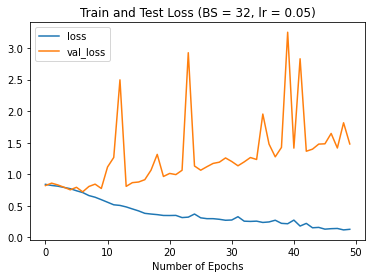

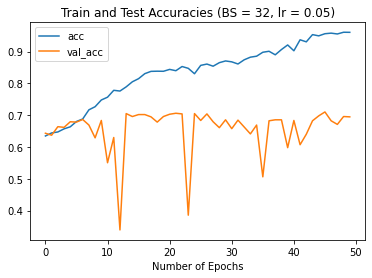

In [16]:
#print time taken
print('time taken:', end-start)

#plot the train and test accuracies
metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (BS = 32, lr = 0.05)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (BS = 32, lr = 0.05)")
ax1.set_xlabel("Number of Epochs")

In [17]:
#overfitting from the previous model as shown by the increasing validation loss

#measures taken to lessen overfitting:
## lower batchsize
## increase dropout

vocab_length = 9242

model2 = Sequential()
#first embedding layer converts each word into a fixed-length vector of defined size
model2.add(Embedding(vocab_length, 20, input_length = fnews_Xtrain.shape[1]))
#prevent overfitting with Dropout which is a type of dropout for convolutional networks
model2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.6))
model2.add(Dense(3,activation="softmax"))

In [20]:
# output model skeleton
learning_rate = 0.05
model2.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),loss="categorical_crossentropy",metrics=['acc'])

In [21]:
batch_size = 16

start = time.time()
history = model2.fit(fnews_Xtrain, fnews_ytrain, validation_data=(fnews_Xtest, fnews_ytest), 
                          epochs = 50, callbacks = early_stop, batch_size = batch_size)
end = time.time()

Epoch 1/50
243/243 [==============================] - 8s 15ms/step - loss: 0.9302 - acc: 0.5955 - val_loss: 0.9291 - val_acc: 0.5887
Epoch 2/50
243/243 [==============================] - 2s 9ms/step - loss: 0.9288 - acc: 0.5955 - val_loss: 0.9229 - val_acc: 0.5887
Epoch 3/50
243/243 [==============================] - 3s 10ms/step - loss: 0.9273 - acc: 0.5957 - val_loss: 0.9153 - val_acc: 0.5887
Epoch 4/50
243/243 [==============================] - 3s 11ms/step - loss: 0.9249 - acc: 0.5955 - val_loss: 0.9098 - val_acc: 0.5887
Epoch 5/50
243/243 [==============================] - 2s 9ms/step - loss: 0.9171 - acc: 0.5957 - val_loss: 0.8959 - val_acc: 0.5887
Epoch 6/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9045 - acc: 0.6024 - val_loss: 0.8731 - val_acc: 0.6124
Epoch 7/50
243/243 [==============================] - 3s 11ms/step - loss: 0.8792 - acc: 0.6158 - val_loss: 0.8469 - val_acc: 0.6268
Epoch 8/50
243/243 [==============================] - 3s 11ms/step - lo

time taken: 82.24257230758667


Text(0.5, 0, 'Number of Epochs')

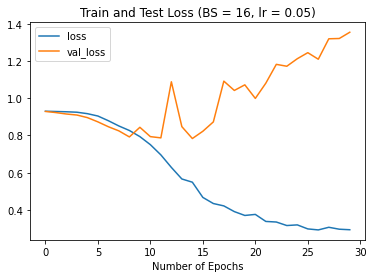

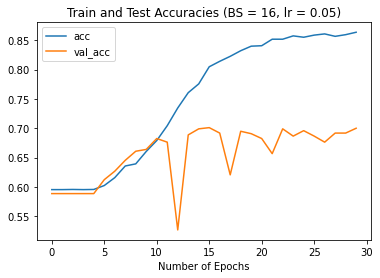

In [22]:
#print time taken
print('time taken:', end-start)

#plot the train and test accuracies
metrics_df_2 = pd.DataFrame(history.history)
ax = metrics_df_2[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (BS = 16, lr = 0.05)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_2[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (BS = 16, lr = 0.05)")
ax1.set_xlabel("Number of Epochs")

In [32]:
#increase neurons in layers

vocab_length = 9242

model3 = Sequential()
#first embedding layer converts each word into a fixed-length vector of defined size
model3.add(Embedding(vocab_length, 20, input_length = fnews_Xtrain.shape[1]))
#prevent overfitting with Dropout which is a type of dropout for convolutional networks
model3.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Bidirectional(LSTM(64)))
model3.add(Dropout(0.6))
model3.add(Dense(3,activation="softmax"))

In [33]:
# output model skeleton
learning_rate = 0.05
model3.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),loss="categorical_crossentropy",metrics=['acc'])

In [34]:
batch_size = 16

start = time.time()
history = model3.fit(fnews_Xtrain, fnews_ytrain, validation_data=(fnews_Xtest, fnews_ytest), 
                          epochs = 50, callbacks = early_stop, batch_size = batch_size)
end = time.time()

Epoch 1/50
243/243 [==============================] - 9s 16ms/step - loss: 0.9406 - acc: 0.5947 - val_loss: 0.9266 - val_acc: 0.5887
Epoch 2/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9330 - acc: 0.5955 - val_loss: 0.9252 - val_acc: 0.5887
Epoch 3/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9307 - acc: 0.5955 - val_loss: 0.9224 - val_acc: 0.5887
Epoch 4/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9283 - acc: 0.5955 - val_loss: 0.9196 - val_acc: 0.5887
Epoch 5/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9270 - acc: 0.5955 - val_loss: 0.9175 - val_acc: 0.5887
Epoch 6/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9258 - acc: 0.5955 - val_loss: 0.9107 - val_acc: 0.5887
Epoch 7/50
243/243 [==============================] - 3s 12ms/step - loss: 0.9210 - acc: 0.5955 - val_loss: 0.9054 - val_acc: 0.5887
Epoch 8/50
243/243 [==============================] - 3s 12ms/step - 

time taken: 153.17399287223816


Text(0.5, 0, 'Number of Epochs')

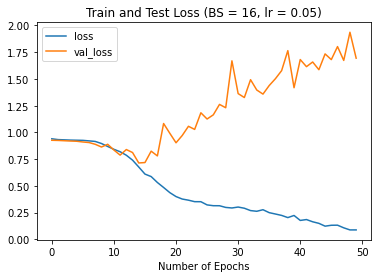

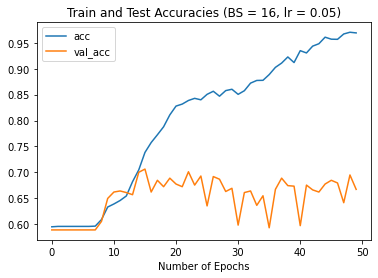

In [35]:
#print time taken
print('time taken:', end-start)

#plot the train and test accuracies
metrics_df_3 = pd.DataFrame(history.history)
ax = metrics_df_3[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (BS = 16, lr = 0.05)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_3[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (BS = 16, lr = 0.05)")
ax1.set_xlabel("Number of Epochs")

# LSTM-B

In [36]:
#import the train and test files for financial news
squidgame_Xtrain = loadtxt('data/train/squidgame_Xtrain_.csv', delimiter=',')
squidgame_Xtest = loadtxt('data/test/squidgame_Xtest_.csv', delimiter=',')
squidgame_ytrain = loadtxt('data/train/squidgame_ytrain_.csv',delimiter=',')
squidgame_ytest = loadtxt('data/test/squidgame_ytest_.csv',delimiter=',')

In [37]:
#convert to array of integers from full precision
squidgame_Xtrain=squidgame_Xtrain.astype(int)
squidgame_Xtest=squidgame_Xtest.astype(int)
squidgame_ytrain=squidgame_ytrain.astype(int)
squidgame_ytest=squidgame_ytest.astype(int)

In [38]:
#check the respective shape of the train and test sets
print('Xtrain:',squidgame_Xtrain.shape, 'ytrain:' ,squidgame_ytrain.shape)
print('Xtest:',squidgame_Xtest.shape, 'ytest:' ,squidgame_ytest.shape)

Xtrain: (948, 831) ytrain: (948, 3)
Xtest: (237, 831) ytest: (237, 3)


In [44]:
#create the LSTM Model
## LSTM is an artificial recurrent neural network architecture and instead of standard feedforward neural network,
## LSTM has feedback connections (signals traveling in both areas)

#from preprocessing
vocab_length = 9066

model = Sequential()
#first embedding layer converts each word into a fixed-length vector of defined size
model.add(Embedding(vocab_length, 20, input_length = squidgame_Xtrain.shape[1]))
#prevent overfitting with Dropout which is a type of dropout for convolutional networks
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(3,activation="softmax"))

In [45]:
# output model skeleton
learning_rate = 0.05
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate),loss="categorical_crossentropy",metrics=['acc'])

In [46]:
# ensure 100 epoch and start training the model
#set batch size to 32
batch_size = 32

start = time.time()
history = model.fit(squidgame_Xtrain, squidgame_ytrain, validation_data=(squidgame_Xtest, squidgame_ytest), 
                          epochs = 50, callbacks = early_stop, batch_size = batch_size)
end = time.time()

Epoch 1/50
30/30 [==============================] - 11s 189ms/step - loss: 0.7578 - acc: 0.7848 - val_loss: 0.5581 - val_acc: 0.8397
Epoch 2/50
30/30 [==============================] - 4s 147ms/step - loss: 0.6438 - acc: 0.7932 - val_loss: 0.5541 - val_acc: 0.8397
Epoch 3/50
30/30 [==============================] - 4s 145ms/step - loss: 0.6453 - acc: 0.7932 - val_loss: 0.5393 - val_acc: 0.8397
Epoch 4/50
30/30 [==============================] - 4s 143ms/step - loss: 0.6422 - acc: 0.7932 - val_loss: 0.5417 - val_acc: 0.8397
Epoch 5/50
30/30 [==============================] - 4s 141ms/step - loss: 0.6316 - acc: 0.7932 - val_loss: 0.5379 - val_acc: 0.8397
Epoch 6/50
30/30 [==============================] - 4s 142ms/step - loss: 0.6407 - acc: 0.7932 - val_loss: 0.5378 - val_acc: 0.8397
Epoch 7/50
30/30 [==============================] - 4s 144ms/step - loss: 0.6346 - acc: 0.7932 - val_loss: 0.5380 - val_acc: 0.8397
Epoch 8/50
30/30 [==============================] - 4s 141ms/step - loss: 0

time taken: 41.071659088134766


Text(0.5, 0, 'Number of Epochs')

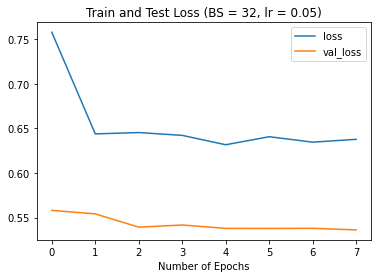

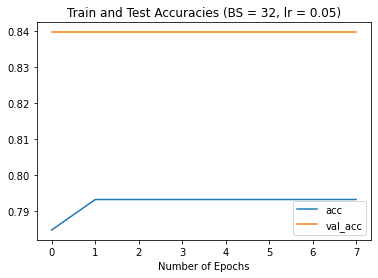

In [47]:
#print time taken
print('time taken:', end-start)

#plot the train and test accuracies
metrics_df_1 = pd.DataFrame(history.history)
ax = metrics_df_1[["loss", "val_loss"]].plot()
ax.set_title("Train and Test Loss (BS = 32, lr = 0.05)")
ax.set_xlabel("Number of Epochs")
ax1 = metrics_df_1[["acc", "val_acc"]].plot()
ax1.set_title("Train and Test Accuracies (BS = 32, lr = 0.05)")
ax1.set_xlabel("Number of Epochs")